In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Projects/Airfoil Self Noise Prediction/airfoil_self_noise.csv'
df=pd.read_csv(data_path, names=['Frequency','AoA', 'Chord','Velocity','Displacement','SPL'])

In [5]:
df.head()

,Frequency,AoA,Chord,Velocity,Displacement,SPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [6]:
print('Number of samples:', df.shape[0])
print('Number of Features:', df.shape[1])
print('List of features:', df.columns.to_list())

Number of samples: 1503
Number of Features: 6
List of features: ['Frequency', 'AoA', 'Chord', 'Velocity', 'Displacement', 'SPL']


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Frequency,1503.0,2886.380572,3152.573137,200.000000,800.000000,1600.000000,4000.000000,20000.000000
AoA,1503.0,6.782302,5.918128,0.000000,2.000000,5.400000,9.900000,22.200000
Chord,1503.0,0.136548,0.093541,0.025400,0.050800,0.101600,0.228600,0.304800
Velocity,1503.0,50.860745,15.572784,31.700000,39.600000,39.600000,71.300000,71.300000
Displacement,1503.0,0.011140,0.013150,0.000401,0.002535,0.004957,0.015576,0.058411
SPL,1503.0,124.835943,6.898657,103.380000,120.191000,125.721000,129.995500,140.987000


#Missing Values

In [8]:
df.isnull().sum()

Frequency       0
AoA             0
Chord           0
Velocity        0
Displacement    0
SPL             0
dtype: int64

There is no missing value in the data.

In [9]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [10]:
X.head()

,Frequency,AoA,Chord,Velocity,Displacement
0,800,0.0,0.3048,71.3,0.002663
1,1000,0.0,0.3048,71.3,0.002663
2,1250,0.0,0.3048,71.3,0.002663
3,1600,0.0,0.3048,71.3,0.002663
4,2000,0.0,0.3048,71.3,0.002663


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [12]:
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)
print('y_train shape : ', y_train.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1127, 5)
X_test shape :  (376, 5)
y_train shape :  (1127,)
y_test shape :  (376,)


#Scaling dataset

In [13]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Model Selection

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
models = [['LinearRegression', LinearRegression()], [ 'KNeighborsRegressor', KNeighborsRegressor()],
          ['RandomForestRegressor', RandomForestRegressor()], ['XGBRegressor', XGBRegressor()]]
models_score = []
for model_name , model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(model_name)
  print('Mean Absolute Error:', mae)
  print('Mean Squared Error:', mse)
  print('R2 :', r2)
  print('----------------------------------------------')
  history = []
  history.append(model_name)
  history.append(mae)
  history.append(mse)
  history.append(r2)
  models_score.append(history)

LinearRegression
Mean Absolute Error: 3.6183804812559153
Mean Squared Error: 22.14845512165388
R2 : 0.5330694346281187
----------------------------------------------
KNeighborsRegressor
Mean Absolute Error: 2.4034303191489363
Mean Squared Error: 10.595364109255325
R2 : 0.7766300481599413
----------------------------------------------
RandomForestRegressor
Mean Absolute Error: 1.2467728989361646
Mean Squared Error: 3.12638076950398
R2 : 0.9340900874460962
----------------------------------------------
[17:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor
Mean Absolute Error: 2.028450443511313
Mean Squared Error: 7.238707138042969
R2 : 0.8473946106867121
----------------------------------------------


In [17]:
score = pd.DataFrame(models_score, columns= ['Model', 'MAE', 'MSE', 'R2'])

In [18]:
score.head()

,Model,MAE,MSE,R2
0,LinearRegression,3.618380,22.148455,0.533069
1,KNeighborsRegressor,2.403430,10.595364,0.776630
2,RandomForestRegressor,1.246773,3.126381,0.934090
3,XGBRegressor,2.028450,7.238707,0.847395


In [19]:
score.sort_values(by = ['MAE'], ascending = True)

,Model,MAE,MSE,R2
2,RandomForestRegressor,1.246773,3.126381,0.934090
3,XGBRegressor,2.028450,7.238707,0.847395
1,KNeighborsRegressor,2.403430,10.595364,0.776630
0,LinearRegression,3.618380,22.148455,0.533069


#Model Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
parameters = {'n_estimators' : [100, 150, 200], 'criterion' : ['mse', 'mae']}
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = parameters, scoring = 'neg_mean_absolute_error', cv = 10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [22]:
print(grid_search.best_score_)
print(grid_search.best_params_)

-1.3550722523308996
{'criterion': 'mse', 'n_estimators': 200}


In [23]:
RFModel = RandomForestRegressor(n_estimators=150, criterion='mse')
RFModel.fit(X_train, y_train)
y_pred = RFModel.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error: ', MAE)

Mean Absolute Error:  1.2876294326241062


In [24]:
LRModel = LinearRegression()
LRModel.fit(X_train, y_train)
KNNModel = KNeighborsRegressor()
KNNModel.fit(X_train, y_train)
RFModel = RandomForestRegressor(n_estimators=150, criterion='mse')
RFModel.fit(X_train, y_train)
XGBModel = XGBRegressor()
XGBModel.fit(X_train, y_train)

[17:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

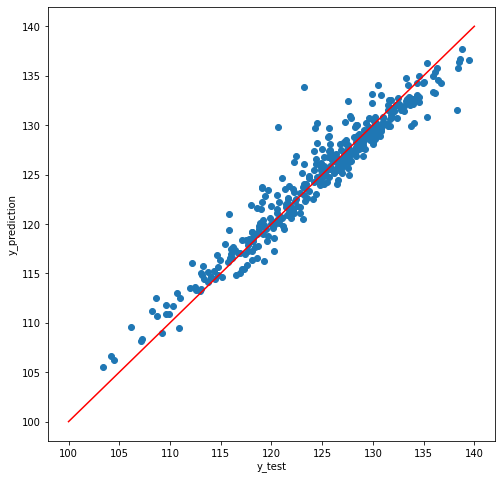

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test,y_pred)
plt.xlabel('y_test')
plt.ylabel('y_prediction')
x = np.linspace(100, 140, num = 2)
plt.plot(x,x, 'r')

#Saving Model

In [28]:
import pickle 
pickle_out = open("LRModel.pkl", mode = "wb") 
pickle.dump(LRModel, pickle_out) 
pickle_out.close()
import pickle 
pickle_out = open("KNNModel.pkl", mode = "wb") 
pickle.dump(KNNModel, pickle_out) 
pickle_out.close()
import pickle 
pickle_out = open("RFModel.pkl", mode = "wb") 
pickle.dump(RFModel, pickle_out) 
pickle_out.close()
import pickle 
pickle_out = open("XGBModel.pkl", mode = "wb") 
pickle.dump(XGBModel, pickle_out) 
pickle_out.close()
# saving the scaler
import pickle 
pickle_out = open("scaler.pkl", mode = "wb") 
pickle.dump(scaler, pickle_out) 
pickle_out.close()

In [29]:
!pip install -q streamlit
!pip install -q pyngrok
!pip install -q streamlit_ace


     |████████████████████████████████| 8.2MB 11.6MB/s 
     |████████████████████████████████| 163kB 58.3MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 112kB 52.0MB/s 
     |████████████████████████████████| 4.2MB 42.6MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 122kB 68.0MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.3 which is incompatible.
     |████████████████████████████████| 747kB 11.3MB/s 
     |████████████████████████████████| 3.9MB 12.4MB/s 


In [11]:
%%writefile airfoil-app.py
 
import pickle
import streamlit as st
import pandas as pd
import numpy as np
import sklearn
import xgboost
from PIL import Image




scaler_path = "/content/scaler.pkl"
scaler = pickle.load(open(scaler_path, 'rb'))
image = Image.open('/content/airfoil.jpg')

def model_selection(model):
  import pickle
  if model == "Linear Regression":
    model_path = "/content/LRModel.pkl"
  elif model == "K Nearest Neighbor":
    model_path = "/content/KNNModel.pkl"
  elif model == "Random Forest":
    model_path = "/content/RFModel.pkl"
  else:
    model_path = "/content/XGBModel.pkl"
  
  model = pickle.load(open(model_path, 'rb'))

  return model

def prediction(Frequency, AoA, Chord, Velocity, Displacement, model):
  Chord /= 100
  Displacement /= 1000
  columns = ['Frequency', 'AoA', 'Chord',  'Velocity', 'Displacement']
  data = {'Frequency' : [Frequency], 'AoA' : [AoA], 'Chord' : [Chord],  'Velocity' : [Velocity], 'Displacement': [Displacement]}
  df = pd.DataFrame(data = data)
  df[columns]=df[columns].astype(float)
  df[columns] = scaler.transform(df[columns])



  
  # Making predictions
  model = model_selection(model)
  prediction = model.predict(df.values)
     
  return prediction[0]
         
  
# this is the main function in which we define our webpage  
def main():       
    # front end elements of the web page 
    html_temp = """ 
    <div style ="background-color:grey;padding:13px"> 
    <h1 style ="color:black;text-align:center;">Airfoil Self-noise Prediction ML App</h1> 
    </div> 
    """
    # display the front end aspect
    st.markdown(html_temp, unsafe_allow_html = True) 
      
    st.image(image)
    """
    
    In this Web Application, you can predict the aerodynamics noise generated by an airfoil using different Machine Learning algorithm
    such as **XGBoost**, **Random Forest**, **K Nearest Neighbor**, and **Linear Regression**. To train this model, I used 
    [**this NASA dataset**](https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise), obtained from a series of aerodynamics and acoustic tests of two and three-dimensional airfoil blade sections. 
    Please enter the values for **Frequency**,
    **Angle of Attack**, **Chord Length**,  **Freestream Velocity**, and **Displacement** using slidbar. Then choose the Machine Learning model and hit the **Predict** button. 
    Please check out the source code for this Web Application at this [**repo**](https://github.com/Masoud-Ghasemian/Airfoil_Self_Noise)
									
    """
    Frequency = st.slider('Frequency (Hz)', 200, 20000, 2000)
    AoA = st.slider('Angle of Attack (Degree)', 0, 20, 10)
    Chord = st.slider('Chord Length (cm)', 2, 20, 10)
    Velocity = st.slider('Freestream Velocity (m/s)', 30, 70, 50)
    Displacement = st.slider('Displacement (mm)', 1, 60, 25)
    model = st.selectbox('Prediction Model',("...","Linear Regression", "K Nearest Neighbor", "Random Forest","XGBoost"))

    result =""

    # when 'Predict' is clicked, make the prediction and store it 
    if st.button("Predict"): 
        result = prediction(Frequency, AoA, Chord, Velocity, Displacement, model)
        st.success('Sound Pressure Level (SPL) : %5.2f dB'%(result))
     
if __name__=='__main__': 
    main()

Overwriting airfoil-app.py


In [2]:
!streamlit run airfoil-app.py &>/dev/null&

In [3]:
from pyngrok import ngrok
 
public_url = ngrok.connect('8501')
public_url

<NgrokTunnel: "http://2057fe481fbb.ngrok.io" -> "http://localhost:8501">

In [ ]:
!pip install pipreqs

In [ ]:
!pipreqs /content/drive/MyDrive/app

In [ ]:
astype()